In [1]:
import pandas as pd
import gs_model.nlp_utils as nu 

ModuleNotFoundError: No module named 'nlp_utils'

In [55]:
'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


In [56]:
'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


In [57]:
df = pd.read_csv("..\data\AI_ML_Challenge_Training_Data_Set_1_v1.csv",encoding='utf-8')

Let's join all the unacceptable text, and acceptable text, and see freqdist

In [58]:
df = df.rename(columns={'Clause ID':'ID', 'Clause Text': 'Input', 'Classification':'Label'})

In [4]:
df.head()

,ID,Input,Label
0,1588,18. Governing Law: This Agreement shall be gov...,0
1,1146,"1.8 Modification. We may modify, update, or di...",1
2,4792,Except as otherwise expressly provided in this...,0
3,2759,8.3. The benefit and burdens of this Ag...,1
4,4400,DEFINITIONS,0


What's the class distribution of labels?

In [5]:
df.Label.value_counts()

0    6407
1    1472
Name: Label, dtype: int64

In [133]:
(6407)/(6407+1472)

0.8131742606929814

In [6]:
#Avg word count by category

df['word_count'] = df['Text'].apply(nu.word_count)
avg_wc = df.groupby('Label').mean().reset_index()
avg_wc[['Label','word_count']]

,Issue,word_count
0,0,72.395505
1,1,130.903533


This is interesting. Avg word count of rejected clauses is significantly higher than the accepted ones.
Let's plot the word count distribution on both the classes

In [7]:
'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


In [8]:
#lets see the max, and min of word counts for each
df.groupby('Issue').agg('max')

,ID,Text,word_count
Issue,,,
0,9269,“Your Materials” means Materials you or any En...,7334
1,9268,☐ Software: _____________________________ Ver...,989


In [9]:
df.groupby('Issue').agg('min')

,ID,Text,word_count
Issue,,,
0,0,"\tAMENDMENTS AND WAIVERS. No modification, ame...",1
1,136,\n \n10.3 Termination by Group Administrator. ...,1


In [10]:
df.groupby('Issue').agg('mean')

,ID,word_count
Issue,,
0,4638.119869,72.395505
1,4624.602582,130.903533


(0.0, 500.0)

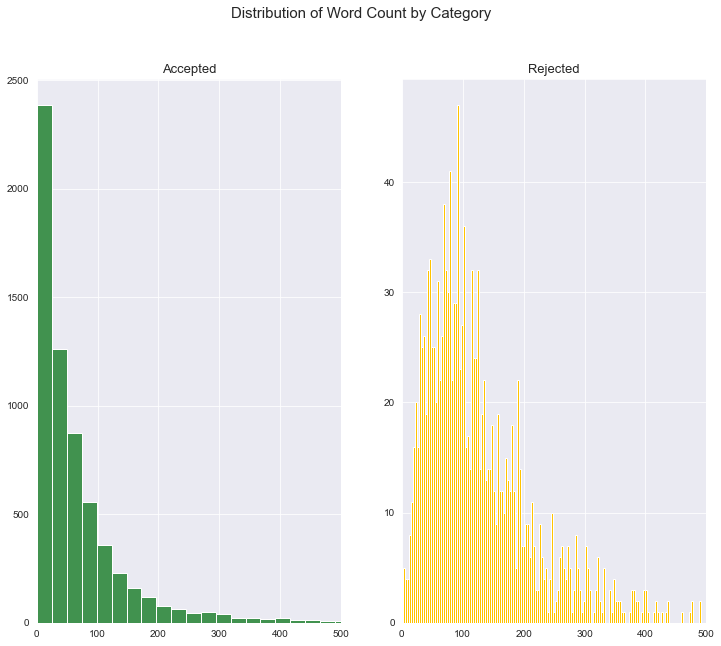

In [11]:
#Plot the distribution of word count by article

fig, ax = plt.subplots(1, 2, figsize = (12,10))
fig.suptitle('Distribution of Word Count by Category', fontsize=15)

bins = 300
df_accepted = df.loc[df['Issue'] == 0] 
df_rejected = df.loc[df['Issue'] == 1] 
ax[0].hist(df_accepted['word_count'], bins = bins, color = '#41924F')
ax[0].set_title('Accepted', fontsize = 13)
ax[0].set_xlim(0, 500)

ax[1].hist(df_rejected['word_count'], bins = bins, color = '#FFC300')
ax[1].set_title('Rejected', fontsize = 13)
ax[1].set_xlim(0, 500)


In [12]:
#Redo the plots, and mean, max, min with unique words
#from nlp_utils import unique_words
df['unique_words'] = df['Text'].apply(nu.unique_words)

In [13]:
df['uwc'] =  df['unique_words'].apply(nu.unique_word_count)

In [14]:
df.head()

,ID,Text,Issue,word_count,unique_words,uwc
0,1588,18. Governing Law: This Agreement shall be gov...,0,117,"{theUnited, enforced, Governing, for, accordan...",74
1,1146,"1.8 Modification. We may modify, update, or di...",1,84,"{for, liability, its, before, else., features)...",57
2,4792,Except as otherwise expressly provided in this...,0,125,"{upon, for, conditions., breach., more, exerci...",67
3,2759,8.3. The benefit and burdens of this Ag...,1,30,"{, benefit, Agreement, or, Supplier, Customer'...",22
4,4400,DEFINITIONS,0,1,{DEFINITIONS},1


(0.0, 100.0)

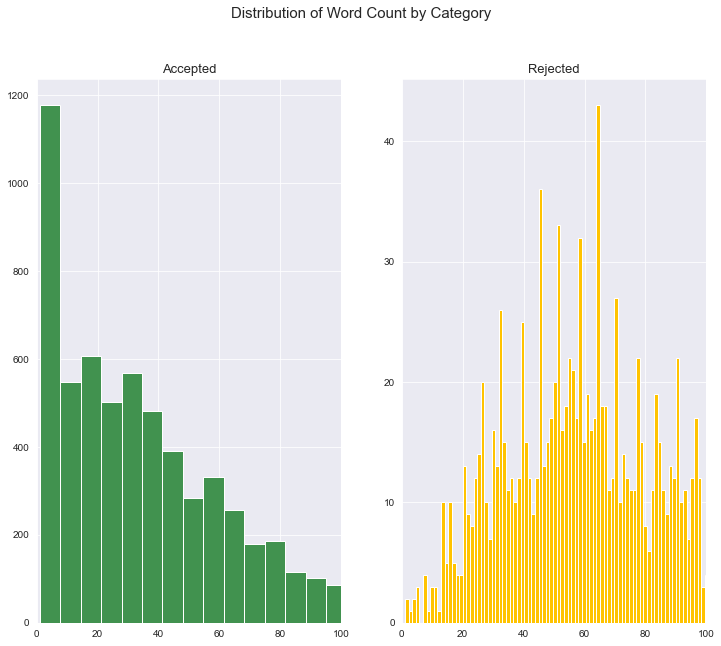

In [15]:
# Plot distribution of unique words by  class
fig, ax = plt.subplots(1, 2, figsize = (12,10))
fig.suptitle('Distribution of Word Count by Category', fontsize=15)

bins = 300
df_accepted = df.loc[df['Issue'] == 0] 
df_rejected = df.loc[df['Issue'] == 1] 
ax[0].hist(df_accepted['uwc'], bins = bins, color = '#41924F')
ax[0].set_title('Accepted', fontsize = 13)
ax[0].set_xlim(0, 100)

ax[1].hist(df_rejected['uwc'], bins = bins, color = '#FFC300')
ax[1].set_title('Rejected', fontsize = 13)
ax[1].set_xlim(0, 100)

In [6]:
import re
#Lets clean the text a bit more, and redo the experiments. Looks like \t, and \n are affecting the numbers
def remove_tabs_returns(text):
    tstring = re.sub('\s+', ' ', str(text))
    return tstring
df['clean_input'] = df['Input'].apply(remove_tabs_returns)

In [7]:
def display_stats(df):
    print(df.groupby('Label').agg('mean'))
    print(df.groupby('Label').agg('max'))
    print(df.groupby('Label').agg('min'))

In [8]:
display_stats(df)

ID
Label             
0      4638.119869
1      4624.602582
         ID                                              Input  \
Label                                                            
0      9269  “Your Materials” means Materials you or any En...   
1      9268  ☐  Software: _____________________________ Ver...   

                                             clean_input  
Label                                                     
0      “Your Materials” means Materials you or any En...  
1      ☐ Software: _____________________________ Vers...  
        ID                                              Input  \
Label                                                           
0        0  \tAMENDMENTS AND WAIVERS. No modification, ame...   
1      136  \n \n10.3 Termination by Group Administrator. ...   

                                             clean_input  
Label                                                     
0                                                         
1

In [19]:
import nlp_utils as nu
cl_text_list = df['unique_words'].tolist()
wf = nu.word_freq(cl_text_list, 20)
wf.head(20)

,0,1
0,the,5663
1,of,5097
2,to,4814
3,and,4673
4,or,4070
5,in,3929
6,any,3283
7,by,3102
8,for,2962
9,a,2876


In [20]:
df_accepted = df.loc[df['Issue'] == 0] 
df_rejected = df.loc[df['Issue'] == 1] 

In [21]:
cl_accepted = df_accepted['unique_words'].tolist()
wf_accepted = nu.word_freq(cl_accepted, 20)
wf_accepted.head(20)

,0,1
0,the,4375
1,of,3858
2,to,3647
3,and,3539
4,or,3022
5,in,2929
6,any,2360
7,by,2253
8,for,2176
9,a,2141


In [22]:
cl_rejected = df_rejected['unique_words'].tolist()
wf_rejected = nu.word_freq(cl_rejected, 20)
wf_rejected.head(20)

,0,1
0,the,1288
1,of,1239
2,,1179
3,to,1167
4,and,1134
5,or,1048
6,in,1000
7,any,923
8,by,849
9,this,801


observations:
 - 'not' appears in both classes;
 - changing the capitilization is important
 - spaces don't seem to be completely eliminated


In [23]:
top_n = 30
bi_accepted = nu.word_freq_bigrams(cl_accepted, top_n=top_n)
bi_rejected = nu.word_freq_bigrams(cl_rejected, top_n=top_n)

In [24]:
df_wf = pd.concat([bi_accepted, bi_rejected], axis=1)
cols = ['accepted', 'count', 'rejected', 'count']
df_wf.columns = cols
df_wf

,accepted,count,rejected,count
0,in,719,in,221
1,and,693,to_Agreement,182
2,of,565,Agreement_or,178
3,the,553,and,177
4,to_or,529,to_or,177
5,or,466,of,170
6,any_of,452,or,161
7,for,439,the,160
8,be_and,435,Customer_to,153
9,to,397,the_may,149


Observations:
- Nothing jumps out using bigrams; mostly stop words.
- Let's remove stop words, and reject to see if it helps

In [59]:
df['no_stop_text'] = df['Input'].apply(nu.process_text)

In [10]:
df['unique_no_stop'] = df['no_stop_text'].apply(set)

In [11]:
df_accepted = df.loc[df['Label'] == 0] 
df_rejected = df.loc[df['Label'] == 1] 

In [12]:
cl_accepted = df_accepted['no_stop_text'].tolist()
cl_rejected = df_rejected['no_stop_text'].tolist()


In [13]:
top_n = 30
bi_accepted = nu.word_freq_bigrams(cl_accepted, top_n=top_n)
bi_rejected = nu.word_freq_bigrams(cl_rejected, top_n=top_n)
df_wf = pd.concat([bi_accepted, bi_rejected], axis=1)
cols = ['accepted', 'count', 'rejected', 'count']
df_wf.columns = cols
df_wf

,accepted,count,rejected,count
0,company,5350,company,1789
1,software,2453,agreement,924
2,agreement,2064,service,840
3,service,1931,customer,788
4,customer,1737,party,712
5,product,1627,software,570
6,use,1626,not,435
7,party,1551,use,416
8,provide,1326,provide,398
9,not,1296,product,348


In [14]:
df.head()

,ID,Input,Label,clean_input,no_stop_text,unique_no_stop
0,1588,18. Governing Law: This Agreement shall be gov...,0,18. Governing Law: This Agreement shall be gov...,"[govern, law, agreement, shall, govern, interp...","{extent, exclusive, arise, conflict-of-laws, g..."
1,1146,"1.8 Modification. We may modify, update, or di...",1,"1.8 Modification. We may modify, update, or di...","[modification, modify, update, discontinue, se...","{unused, time, effort, entirety, feature, reas..."
2,4792,Except as otherwise expressly provided in this...,0,Except as otherwise expressly provided in this...,"[expressly, provide, agreement, waiver, covena...","{unless, set, respect, option, provide, agreem..."
3,2759,8.3. The benefit and burdens of this Ag...,1,8.3. The benefit and burdens of this Agreement...,"[benefit, burden, agreement, not, assign, tran...","{transfer, benefit, burden, supplier, not, agr..."
4,4400,DEFINITIONS,0,DEFINITIONS,[definition],{definition}


In [21]:
'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier


In [65]:
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'K Nearest Neighbor': KNeighborsClassifier()}


In [128]:
df.head()

,ID,Text,Issue,word_count,unique_words,uwc,clean_text,no_stop_text,unique_no_stop
0,1588,18. Governing Law: This Agreement shall be gov...,0,117,"{theUnited, enforced, Governing, for, accordan...",74,18. Governing Law: This Agreement shall be gov...,"[govern, law, agreement, shall, govern, interp...","{maximum, govern, accordance, remainder, refer..."
1,1146,"1.8 Modification. We may modify, update, or di...",1,84,"{for, liability, its, before, else., features)...",57,"1.8 Modification. We may modify, update, or di...","[modification, modify, update, discontinue, se...","{liability, software, change, provide, include..."
2,4792,Except as otherwise expressly provided in this...,0,125,"{upon, for, conditions., breach., more, exerci...",67,Except as otherwise expressly provided in this...,"[expressly, provide, agreement, waiver, covena...","{exercise, unless, provide, set, provision, wa..."
3,2759,8.3. The benefit and burdens of this Ag...,1,30,"{, benefit, Agreement, or, Supplier, Customer'...",22,8.3. The benefit and burdens of this Agreement...,"[benefit, burden, agreement, not, assign, tran...","{write, consent, transfer, not, supplier, assi..."
4,4400,DEFINITIONS,0,1,{DEFINITIONS},1,DEFINITIONS,[definition],{definition}


In [172]:
from sklearn.model_selection import train_test_split

#def run_a_model(model, vectorizer, n_test_size, df, f_label='Feature', o_label = 'Lables'):
def run_a_model(model, vectorizer, n_test_size, df, reduce=False):
    #get the train_test_split
    train_X, test_X, train_Y, test_Y = train_test_split(df['no_stop_text'],df['Label'],test_size=n_test_size, stratify=df['Label'], random_state=3)
    vectorizer.fit(df['no_stop_text'].astype(str))
    train_X_vec = vectorizer.transform(train_X.astype(str))
    test_X_vec = vectorizer.transform(test_X.astype(str))

    if reduce:
        lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)
        train_X_vec = lsa.fit_transform(train_X_vec)
        test_X_vec = lsa.fit_transform(test_X_vec)

    print(train_X_vec.shape, test_X_vec.shape, train_Y.shape, test_Y.shape)

    #fit the model
    model.fit(train_X_vec, train_Y)
    y_pred = model.predict(test_X_vec)
    ac_score = (accuracy_score(test_Y, y_pred))
    p_score = precision_score(test_Y, y_pred, average='macro')
    r_score= (recall_score(test_Y, y_pred, average='macro'))
    f1score = (f1_score(test_Y, y_pred, average='macro'))
    return ac_score, p_score, r_score, f1score

In [24]:
vectorizers_list = ['TF-IDF1', 'TF-IDF2', 'TF-IDF3']

In [169]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_vectorizer(vector, n_max_features):
    if vector == 'TF-IDF1':
        vectorizer = TfidfVectorizer(max_features=n_max_features)
    elif vector == 'TF-IDF2':
        vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)
    elif vector == 'TF-IDF3':
        vectorizer  = TfidfVectorizer(ngram_range=(2, 2), 
                                   min_df = 2, 
                                   max_df = .95)                                     
    else:
        pass
    return vectorizer

                            

In [170]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
vectorizer_name = []
for vec_name in vectorizers_list:
    for model_k,model_v in model_dict.items():
        print("Running model:",model_k, "vectorizer:",vec_name)
        vectorizer = get_vectorizer(vec_name, 2000)
        #ac_score, p_score, r_score, f1score = run_a_model(model_v,vectorizer, 0.3, 'no_stop_text', 'Issue')
        ac_score, p_score, r_score, f1score = run_a_model(model_v,vectorizer, 0.3, df)
        model_name.append(model_k)
        vectorizer_name.append(vec_name)
        ac_score_list.append(ac_score)
        p_score_list.append(p_score)
        r_score_list.append(r_score)
        f1_score_list.append(f1score)
model_comparison_df = pd.DataFrame([vectorizer_name, model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
model_comparison_df.columns = ['vec_name','model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
model_comparison_df

Running model: Dummy vectorizer: TF-IDF1


NameError: name 'run_a_model' is not defined

In [149]:
from sklearn.decomposition import TruncatedSVD
model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
vectorizer_name = []
for model_k,model_v in model_dict.items():
    print("Running model:",model_k, "vectorizer:",vec_name)
    vectorizer = get_vectorizer('TF-IDF3', 2000)
    #ac_score, p_score, r_score, f1score = run_a_model(model_v,vectorizer, 0.3, 'no_stop_text', 'Issue')
    ac_score, p_score, r_score, f1score = run_a_model(model_v,vectorizer, 0.3, df, True)
    model_name.append(model_k)
    vectorizer_name.append('TD-IDF3')
    ac_score_list.append(ac_score)
    p_score_list.append(p_score)
    r_score_list.append(r_score)
    f1_score_list.append(f1score)
new_df = pd.DataFrame([vectorizer_name, model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
new_df.columns = ['vec_name','model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#new_df = new_df.sort_values(by='f1_score', ascending=False)
model_comparison_df = model_comparison_df.append(new_df,ignore_index=True)
model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)


Running model: Dummy vectorizer: TF-IDF2
(5515, 100) (2364, 100) (5515,) (2364,)
Running model: Stochastic Gradient Descent vectorizer: TF-IDF2
(5515, 100) (2364, 100) (5515,) (2364,)
Running model: Random Forest vectorizer: TF-IDF2
(5515, 100) (2364, 100) (5515,) (2364,)
Running model: Decsision Tree vectorizer: TF-IDF2
(5515, 100) (2364, 100) (5515,) (2364,)
Running model: AdaBoost vectorizer: TF-IDF2
(5515, 100) (2364, 100) (5515,) (2364,)
Running model: K Nearest Neighbor vectorizer: TF-IDF2
(5515, 100) (2364, 100) (5515,) (2364,)


In [150]:
model_comparison_df = model_comparison_df.append(new_df,ignore_index=True)
model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)

model_comparison_df


,vec_name,model_name,accuracy_score,precision_score,recall_score,f1_score
0,TF-IDF2,AdaBoost,0.840948,0.744389,0.667866,0.692683
1,TF-IDF1,Stochastic Gradient Descent,0.848562,0.783128,0.648158,0.679893
2,TF-IDF1,AdaBoost,0.835025,0.730531,0.656384,0.679784
3,TD-IDF3,AdaBoost,0.821912,0.698516,0.625672,0.645771
4,TF-IDF2,Decsision Tree,0.788071,0.647088,0.640574,0.643636
5,TD-IDF3,Decsision Tree,0.786379,0.639655,0.627338,0.632745
6,TF-IDF2,Stochastic Gradient Descent,0.837986,0.772695,0.605941,0.629683
7,TF-IDF1,Decsision Tree,0.775804,0.630039,0.628674,0.629347
8,TD-IDF3,Stochastic Gradient Descent,0.826988,0.723429,0.592208,0.610182
9,TD-IDF3,K Nearest Neighbor,0.812183,0.668796,0.588329,0.602996


In [29]:
#prepping for gridsearc
# need transformed vectors
vectorizer = get_vectorizer('TF-IDF2', 2000)
X = vectorizer.fit_transform(df['no_stop_text'].astype(str))
y = df['Label'].values

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

In [31]:
#Hyperparameter tuning
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!


#SGD
loss =  ['log']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [5, 1000, 10000]
tol = [None, 1e-3]
eta0 = [0.1, 0.001]

random_state = [3]

clf = SGDClassifier()

params = dict(loss=loss,
              penalty=penalty,
              alpha=alpha,
              max_iter=max_iter,
              tol=tol,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

sgd_best_model = gridsearch.fit(X, y)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 17.9min finished


In [157]:
sgd_best_model

GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [1e-06, 0.001, 0.1, 1.0], 'loss': ['log'],
                         'max_iter': [5, 1000, 10000], 'penalty': ['l2', 'l1'],
                         'random_state': [3], 'tol': [None, 0.001]},
             verbose=1)

In [32]:
import pickle

In [33]:
pickle.dump(sgd_best_model, open('sgd_best_model.pkl','wb'))

In [34]:
pickle.dump(X,open("test_X.pkl",'wb'))

In [35]:
pickle.dump(y,open('test_Y.pkl','wb'))

In [39]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [40]:
#Plot AUC - SGD
y_b = label_binarize(y, classes = [0, 1])
n_classes = y_b.shape[1]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)


In [41]:
y_score = sgd_best_model.fit(X_train_b, y_train_b).predict_proba(X_test_b)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 11.8min finished


In [42]:
y_score.shape

(2364, 2)

In [58]:
#Compute ROC curve and ROC area for each class

fpr, tpr, thresholds = roc_curve(y_test_b, y_score[:,1])
roc_auc = auc(fpr, tpr)

In [47]:
roc_auc

0.8270502069394156

In [48]:
import numpy as np
#First aggregate all false positive rates
all_fpr = np.unique(fpr)

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)

In [218]:
mean_tpr += np.interp(all_fpr, fpr, tpr)

In [219]:
roc_auc  = auc(all_fpr, mean_tpr)

In [220]:
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')

<Figure size 936x720 with 0 Axes>

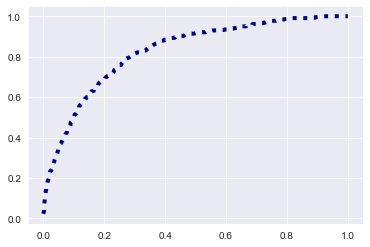

In [221]:
plt.plot(all_fpr, 
         mean_tpr, 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc),
         color='navy', 
         linestyle=':', 
         linewidth=4)

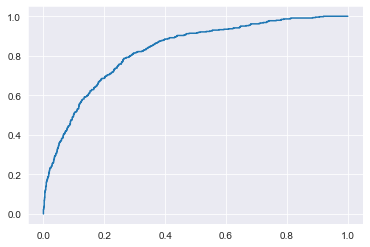

In [63]:
plt.plot(fpr,tpr)

In [64]:
sgd_best_model

GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [1e-06, 0.001, 0.1, 1.0], 'loss': ['log'],
                         'max_iter': [5, 1000, 10000], 'penalty': ['l2', 'l1'],
                         'random_state': [3], 'tol': [None, 0.001]},
             verbose=1)

In [65]:
sgd_best_model.best_params_

{'alpha': 1e-06,
 'loss': 'log',
 'max_iter': 10000,
 'penalty': 'l2',
 'random_state': 3,
 'tol': None}

In [66]:
sgd_best_model = gridsearch.best_params_

In [67]:
sgd_best_model

{'alpha': 1e-06,
 'loss': 'log',
 'max_iter': 10000,
 'penalty': 'l2',
 'random_state': 3,
 'tol': None}

In [68]:
sgd_best_params = sgd_best_model

In [69]:
sgd_best_model = SGDClassifier().set_params(sgd_best_params)

TypeError: set_params() takes 1 positional argument but 2 were given

In [1]:
#load the best sgd classifier via pickle
import pickle
sgd_best_model = pickle.load(open('sgd_best_model.pkl','rb'))

In [2]:
sgd_best_model

GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [1e-06, 0.001, 0.1, 1.0], 'loss': ['log'],
                         'max_iter': [5, 1000, 10000], 'penalty': ['l2', 'l1'],
                         'random_state': [3], 'tol': [None, 0.001]},
             verbose=1)

In [3]:
X = pickle.load(open('test_X.pkl','rb'))
y = pickle.load(open('test_Y.pkl','rb'))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

In [8]:
sgd_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = sgd_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 



Fitting 5 folds for each of 48 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 11.0min finished


NameError: name 'pd' is not defined

In [9]:
import pandas as pd

In [28]:
def show_confusion_matrix(cm):
    cm_df = pd.DataFrame(cm,
                     index = ['Accepted','Refused'], 
                     columns = ['Accepted','Refused'])

    #Plot the heatmap
    plt.figure(figsize=(12, 8))

    sns.heatmap(cm_df, 
                center=0, 
                cmap=sns.diverging_palette(220, 15, as_cmap=True), 
                annot=True, 
                fmt='g')

    plt.title('SGD (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
    plt.ylabel('True label', fontsize = 13)
    plt.xlabel('Predicted label', fontsize = 13)
    plt.show()

In [12]:
sgd_best_params = sgd_best_model.best_params_

In [18]:
def build_model_from_params(params):
    sgd_best_model = SGDClassifier(alpha=params['alpha'],
                               loss=params['loss'],
                               max_iter=params['max_iter'],
                               penalty=params['penalty'],
                               random_state = params['random_state'],
                               tol=params['tol'])
    return sgd_best_model

In [19]:
sgd_best_model = build_model_from_params(sgd_best_params)

In [20]:
sgd_classifier = OneVsRestClassifier(sgd_best_model)

In [21]:
y_score = sgd_classifier.fit(X_train, y_train).predict_proba(X_test)

In [22]:
y_score.shape

(2364, 2)

In [23]:
y_score[1]

array([0.96216289, 0.03783711])

In [24]:
y_test[1]

0

In [25]:
y_pred = (y_score[:,1] > 0.5)

In [26]:
cm = confusion_matrix(y_test, y_pred)

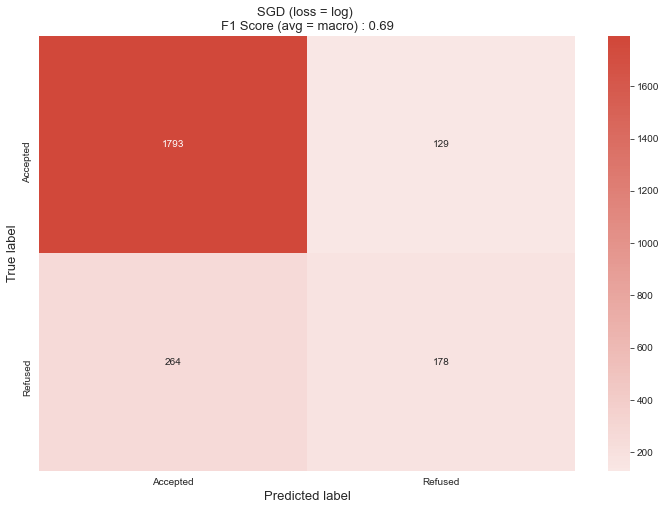

In [29]:
show_confusion_matrix(cm)

In [42]:
y_pred = (y_score[:,1] > 0.0001)

In [43]:
cm = confusion_matrix(y_test, y_pred)

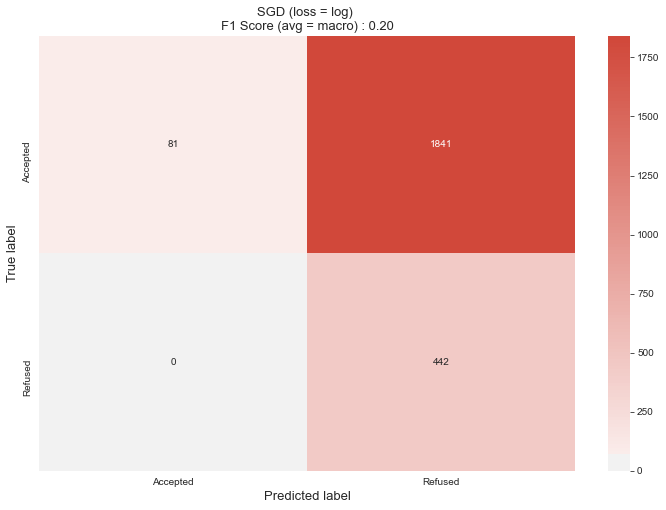

In [44]:
show_confusion_matrix(cm)

In [52]:
import numpy as np

In [51]:
embeddings_dict = {}
with open('../data/glove.6B.50d.txt','r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [73]:
import nltk
docs_vectors = pd.DataFrame() # creating empty final dataframe
stopwords = nltk.corpus.stopwords.words('english') # removing stop words
for doc in df['Input'].str.lower().str.replace('[^a-z ]', ''): # looping through each document and cleaning it
    temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
    for word in doc.split(' '): # looping through each word of a single document and spliting through space
        if word not in stopwords: # if word is not present in stopwords then (try)
            try:
                word_vec = embeddings_dict[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                temp = temp.append(pd.Series(word_vec), ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                pass
    doc_vector = temp.mean() # take the average of each column(w0, w1, w2,........w300)
    docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append each document value to the final dataframe
docs_vectors.shape

AttributeError: 'list' object has no attribute 'split'

In [61]:
type(docs_vectors)

pandas.core.frame.DataFrame

In [62]:
docs_vectors['label'] = df['Label']

In [63]:
docs_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,label
0,0.087543,-0.097304,-0.374919,-0.017222,0.234065,0.228364,0.135592,-0.052565,0.186356,-0.177624,...,-0.294665,0.497460,0.340944,-0.708516,0.045398,-0.398820,0.565895,-0.069211,-0.010381,0
1,0.294189,-0.030023,0.246555,-0.039709,-0.090185,0.134284,-0.372906,-0.070331,0.243900,0.121721,...,-0.206432,0.057386,0.477484,-0.331296,-0.146403,0.019886,0.396003,0.017418,0.337412,1
2,0.084118,0.035351,-0.300121,-0.109478,0.067099,0.365030,0.038824,0.059006,0.094117,0.000322,...,-0.410886,0.335433,0.400181,-0.546495,-0.092111,-0.436820,0.637287,-0.040219,-0.015709,0
3,0.424600,0.012972,-0.001912,-0.162233,0.225573,0.408753,-0.286126,0.159538,0.219987,-0.164786,...,-0.246758,0.316186,0.187015,-0.510267,-0.074293,-0.361806,0.377443,-0.227524,0.239867,1
4,0.027986,0.229090,-0.638620,-0.431710,-0.107550,0.527920,0.829680,-1.529700,-0.294540,-0.154160,...,-0.503940,1.022500,1.475500,-0.999110,0.062379,1.296900,1.416600,0.078200,-0.184380,0


In [176]:
from sklearn.model_selection import train_test_split
docs_vectors = docs_vectors.dropna()

train_x, test_x, train_y, test_y = train_test_split(docs_vectors.drop('label', axis = 1),
                                                   docs_vectors['label'],
                                                   test_size = 0.3,
                                                   random_state = 1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((4064, 300), (4064,), (1742, 300), (1742,))

In [177]:
def fit_predict_a_model(model, train_X, test_X, train_Y, test_Y):
    #get the train_test_split

    #fit the model
    model.fit(train_X, train_Y)
    y_pred = model.predict(test_X)
    ac_score = (accuracy_score(test_Y, y_pred))
    p_score = precision_score(test_Y, y_pred, average='macro')
    r_score= (recall_score(test_Y, y_pred, average='macro'))
    f1score = (f1_score(test_Y, y_pred, average='macro'))
    return ac_score, p_score, r_score, f1score

In [178]:
model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
vectorizer_name = []
for model_k,model_v in model_dict.items():
    print("Running model:",model_k, "vectorizer: Glove")
    #ac_score, p_score, r_score, f1score = run_a_model(model_v,vectorizer, 0.3, 'no_stop_text', 'Issue')
    ac_score, p_score, r_score, f1score = fit_predict_a_model(model_v,train_x, test_x, train_y, test_y)
    model_name.append(model_k)
    vectorizer_name.append('Glove')
    ac_score_list.append(ac_score)
    p_score_list.append(p_score)
    r_score_list.append(r_score)
    f1_score_list.append(f1score)
new_df = pd.DataFrame([vectorizer_name, model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
new_df.columns = ['vec_name','model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
model_comparison_df = new_df.sort_values(by='f1_score', ascending=False)


Running model: Dummy vectorizer: Glove
Running model: Stochastic Gradient Descent vectorizer: Glove
Running model: Random Forest vectorizer: Glove
Running model: Decsision Tree vectorizer: Glove
Running model: AdaBoost vectorizer: Glove
Running model: K Nearest Neighbor vectorizer: Glove


In [179]:
model_comparison_df

,vec_name,model_name,accuracy_score,precision_score,recall_score,f1_score
3,Glove,Decsision Tree,0.65442,0.519688,0.520434,0.519939
5,Glove,K Nearest Neighbor,0.735936,0.524405,0.50988,0.491322
0,Glove,Dummy,0.653846,0.490219,0.490994,0.490182
2,Glove,Random Forest,0.759472,0.510723,0.501362,0.453978
1,Glove,Stochastic Gradient Descent,0.764638,0.516124,0.50119,0.447268
4,Glove,AdaBoost,0.75775,0.479639,0.497603,0.446829


In [77]:
embeddings300d_dict = {}
with open('../data/glove.6B.300d.txt','r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings300d_dict[word] = vector

In [78]:
import nltk
docs_vectors = pd.DataFrame() # creating empty final dataframe
for doc in df['no_stop_text']: # looping through each document and cleaning it
    temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
    for word in doc: # looping through each word of a single document and spliting through space
        try:
            word_vec = embeddings300d_dict[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
            temp = temp.append(pd.Series(word_vec), ignore_index = True) # if word is present then append it to temporary dataframe
        except:
            pass
    doc_vector = temp.mean() # take the average of each column(w0, w1, w2,........w300)
    docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append each document value to the final dataframe
docs_vectors['label'] = df['Label']
docs_vectors.shape

(7879, 301)

In [82]:
extra_training = pickle.load(open('../reference/train.pkl','rb'))

In [83]:
type(extra_training)

list

In [86]:
type(extra_training[0])

dict

In [88]:
extra_training[0].keys()

dict_keys(['text', 'target'])

In [89]:
extra_df = pd.DataFrame(extra_training)

In [90]:
extra_df.head()

,text,target
0,statement work local commerci commun servic ge...,0
1,combin commerci item accord format far subpart...,0
2,amend contract amend modif effect date contrac...,0
3,perform work statement electron document manag...,0
4,statement background center devic radiolog hea...,1


In [92]:
extra_df.target.value_counts()

0    722
1    271
Name: target, dtype: int64

In [ ]:
#can use extra_df for trainign word embeddings

In [93]:
df.head()

,ID,Input,Label,no_stop_text
0,1588,18. Governing Law: This Agreement shall be gov...,0,"[govern, law, agreement, shall, govern, interp..."
1,1146,"1.8 Modification. We may modify, update, or di...",1,"[modification, modify, update, discontinue, se..."
2,4792,Except as otherwise expressly provided in this...,0,"[expressly, provide, agreement, waiver, covena..."
3,2759,8.3. The benefit and burdens of this Ag...,1,"[benefit, burden, agreement, not, assign, tran..."
4,4400,DEFINITIONS,0,[definition]


In [95]:
df.columns

Index(['ID', 'Input', 'Label', 'no_stop_text'], dtype='object')

In [100]:
def get_len(x):
    return len(x)
df['wc'] = df['no_stop_text'].apply(get_len)

In [101]:
df.head()

,ID,Input,Label,no_stop_text,wc
0,1588,18. Governing Law: This Agreement shall be gov...,0,"[govern, law, agreement, shall, govern, interp...",59
1,1146,"1.8 Modification. We may modify, update, or di...",1,"[modification, modify, update, discontinue, se...",33
2,4792,Except as otherwise expressly provided in this...,0,"[expressly, provide, agreement, waiver, covena...",52
3,2759,8.3. The benefit and burdens of this Ag...,1,"[benefit, burden, agreement, not, assign, tran...",10
4,4400,DEFINITIONS,0,[definition],1


In [102]:
len(df[df['wc']<3])

748

In [120]:
short_df = df[df['wc']<5]

In [121]:
short_df.Label.value_counts()

0    1109
1       7
Name: Label, dtype: int64

In [115]:
short_df[short_df['Label']==1]

,ID,Input,Label,no_stop_text,wc,ctag
694,7175,Sales Order Form,1,"[sale, order, form]",3,False
2107,4182,"COPYING, INSTALLING OR USING",1,"[copying, instal, use]",3,False
4412,4061,CONFIDENTIAL PROPERTY OF COMPANY,1,"[confidential, property, company]",3,True
4446,3675,Company Confidential,1,"[company, confidential]",2,True
5328,3621,Company\nCONFIDENTIAL\n,1,"[company, confidential]",2,True
6847,6827,Proprietary & Confidential,1,"[proprietary, confidential]",2,True


In [122]:
short_df = df[df['wc']>4]

In [123]:
short_df.Label.value_counts()

0    5298
1    1465
Name: Label, dtype: int64

In [124]:
(1465)/(5298+1465)

0.2166198432648233

In [137]:
#lets plot a cumulative word distribution w.r.t wc 
pos_sents = []
neg_sents = []
len_sents = []
for uwc in df['wc'].unique():
    len_sents.append(uwc)
    pos_len= len(df[ (df['wc']==uwc) & (df['Label']==0)])
    neg_len= len(df[ (df['wc']==uwc) & (df['Label']==1)])
    pos_sents.append(pos_len)
    neg_sents.append(neg_len)
wc_df = pd.DataFrame([len_sents, pos_sents, neg_sents]).T
wc_df.columns = ['word_count','no_accepted','no_rejected']


In [144]:
wc_df = wc_df.sort_values(by=['word_count'])

In [148]:
temp_df = wc_df.cumsum()

In [149]:
temp_df.head()

,word_count,no_accepted,no_rejected
140,0,25,0
4,1,393,0
14,3,745,3
10,6,951,6
59,10,1109,7


In [150]:
temp_df['word_count'] = wc_df['word_count']

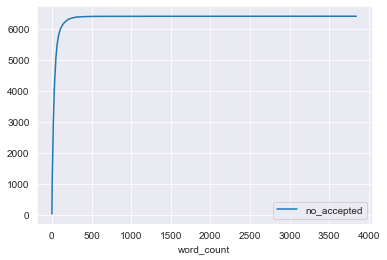

In [152]:
ax = temp_df.plot(x='word_count', y='no_accepted')

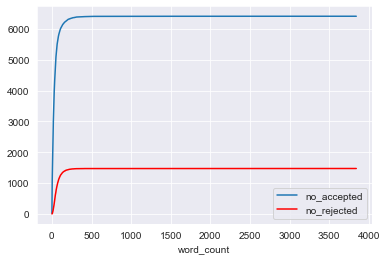

In [155]:
ax = temp_df.plot(x='word_count', y='no_accepted')
temp_df.plot(x='word_count', y='no_rejected', color='red', ax=ax)

In [156]:
t_df = temp_df[ temp_df['word_count'] < 10]

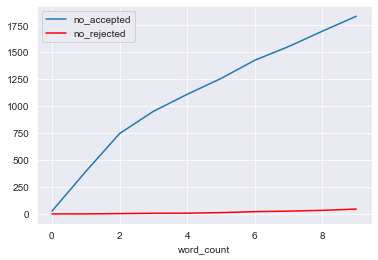

In [157]:
ax = t_df.plot(x='word_count', y='no_accepted')
t_df.plot(x='word_count', y='no_rejected', color='red', ax=ax)

In [160]:
total_accepted = wc_df['no_accepted'].sum()
total_rejected = wc_df['no_rejected'].sum()
t_df['ratio'] = (total_accepted - t_df['no_accepted']) / (total_accepted+total_rejected - (t_df['no_accepted'] + t_df['no_rejected']))

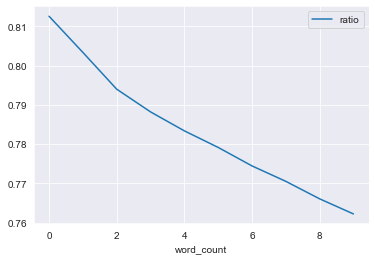

In [161]:
ax = t_df.plot(x='word_count', y='ratio')


In [ ]:
#removing vectors with less than 5 stop words

In [162]:
wc_df.head()

,word_count,no_accepted,no_rejected
140,0,25,0
4,1,368,0
14,2,352,3
10,3,206,3
59,4,158,1


In [163]:
train_df = df[ df['wc'] > 4]

In [164]:
len(train_df)

6763

In [165]:
train_df.columns

Index(['ID', 'Input', 'Label', 'no_stop_text', 'wc', 'ctag'], dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

In [167]:
vectorizers_list = ['TF-IDF1', 'TF-IDF2', 'TF-IDF3']

In [173]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
vectorizer_name = []
for vec_name in vectorizers_list:
    for model_k,model_v in model_dict.items():
        print("Running model:",model_k, "vectorizer:",vec_name)
        vectorizer = get_vectorizer(vec_name, 2000)
        #ac_score, p_score, r_score, f1score = run_a_model(model_v,vectorizer, 0.3, 'no_stop_text', 'Issue')
        ac_score, p_score, r_score, f1score = run_a_model(model_v,vectorizer, 0.3, train_df)
        model_name.append(model_k)
        vectorizer_name.append(vec_name)
        ac_score_list.append(ac_score)
        p_score_list.append(p_score)
        r_score_list.append(r_score)
        f1_score_list.append(f1score)
model_comparison_df = pd.DataFrame([vectorizer_name, model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
model_comparison_df.columns = ['vec_name','model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
model_comparison_df

Running model: Dummy vectorizer: TF-IDF1
(4734, 2000) (2029, 2000) (4734,) (2029,)
Running model: Stochastic Gradient Descent vectorizer: TF-IDF1
(4734, 2000) (2029, 2000) (4734,) (2029,)
Running model: Random Forest vectorizer: TF-IDF1
(4734, 2000) (2029, 2000) (4734,) (2029,)
Running model: Decsision Tree vectorizer: TF-IDF1
(4734, 2000) (2029, 2000) (4734,) (2029,)
Running model: AdaBoost vectorizer: TF-IDF1
(4734, 2000) (2029, 2000) (4734,) (2029,)
Running model: K Nearest Neighbor vectorizer: TF-IDF1
(4734, 2000) (2029, 2000) (4734,) (2029,)
Running model: Dummy vectorizer: TF-IDF2
(4734, 42066) (2029, 42066) (4734,) (2029,)
Running model: Stochastic Gradient Descent vectorizer: TF-IDF2
(4734, 42066) (2029, 42066) (4734,) (2029,)
Running model: Random Forest vectorizer: TF-IDF2
(4734, 42066) (2029, 42066) (4734,) (2029,)
Running model: Decsision Tree vectorizer: TF-IDF2
(4734, 42066) (2029, 42066) (4734,) (2029,)
Running model: AdaBoost vectorizer: TF-IDF2
(4734, 42066) (2029, 420

,vec_name,model_name,accuracy_score,precision_score,recall_score,f1_score
1,TF-IDF1,Stochastic Gradient Descent,0.823066,0.757575,0.655316,0.681015
10,TF-IDF2,AdaBoost,0.813208,0.727917,0.65724,0.678279
4,TF-IDF1,AdaBoost,0.810744,0.722241,0.655667,0.675814
16,TF-IDF3,AdaBoost,0.808773,0.721004,0.639618,0.660456
3,TF-IDF1,Decsision Tree,0.762445,0.652261,0.655233,0.653699
5,TF-IDF1,K Nearest Neighbor,0.796451,0.692143,0.627642,0.644709
7,TF-IDF2,Stochastic Gradient Descent,0.81518,0.754011,0.621522,0.643514
11,TF-IDF2,K Nearest Neighbor,0.796944,0.693534,0.620562,0.637775
9,TF-IDF2,Decsision Tree,0.761952,0.64269,0.632732,0.637134
15,TF-IDF3,Decsision Tree,0.762445,0.642958,0.632225,0.636924


In [174]:
del short_df
del temp_df

In [175]:
import nltk
docs_vectors = pd.DataFrame() # creating empty final dataframe
for doc in train_df['no_stop_text']: # looping through each document and cleaning it
    temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
    for word in doc: # looping through each word of a single document and spliting through space
        try:
            word_vec = embeddings300d_dict[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
            temp = temp.append(pd.Series(word_vec), ignore_index = True) # if word is present then append it to temporary dataframe
        except:
            pass
    doc_vector = temp.mean() # take the average of each column(w0, w1, w2,........w300)
    docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append each document value to the final dataframe
docs_vectors['label'] = train_df['Label']
docs_vectors.shape

(6763, 301)